<a href="https://colab.research.google.com/github/ARROW12/Hacktoberfest-1/blob/master/GoogleAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import os

In [18]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange
from google.analytics.data_v1beta.types import Dimension
from google.analytics.data_v1beta.types import Metric
from google.analytics.data_v1beta.types import RunReportRequest
from google.analytics.data_v1beta.types import OrderBy

In [19]:
## Set up global variables

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'Quickstart-5585e1e3e5db.json'
property_id = '368780194'

client = BetaAnalyticsDataClient()

In [20]:
## Format Report - run_report method
def format_report(request):
    response = client.run_report(request)
    
    # Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])

    row_index_named = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])

    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')), 
                          index = row_index_named, columns = metric_names)
    return output

In [21]:
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date="2022-06-01", end_date="today")],
    )

request

property: "properties/368780194"
dimensions {
  name: "month"
}
dimensions {
  name: "sessionMedium"
}
metrics {
  name: "averageSessionDuration"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2022-06-01"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}
order_bys {
  dimension {
    dimension_name: "sessionMedium"
  }
}

In [23]:
format_report(request)

,,averageSessionDuration,activeUsers
month,sessionMedium,,
04,(none),198.189011,8.0


In [12]:
output_df = format_report(request)

## Export to Excel
output_df.reset_index().to_excel('GA4_python_output.xlsx', sheet_name = 'GA4_report', engine = 'xlsxwriter')

In [14]:
## Export to CSV
output_df.to_csv('GA4_python_output.csv')

In [26]:
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
monhtly_users_pivot = pd.pivot_table(output_df, 
                                     columns=['sessionMedium'], 
                                     index=['month'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)

In [28]:
monhtly_users_pivot

sessionMedium,(none)
month,
04,8


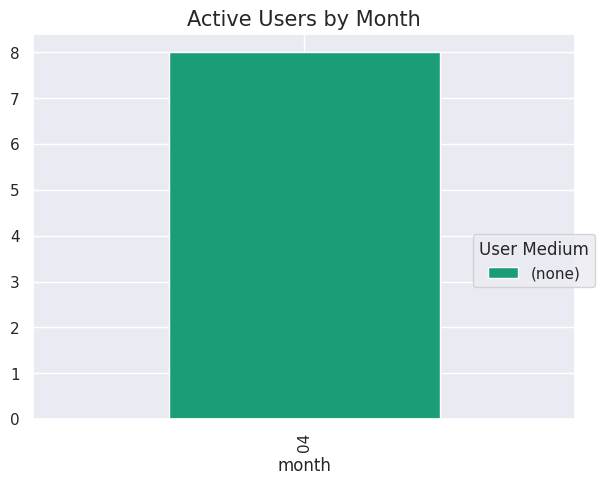

In [30]:
sns.set_theme()
monhtly_users_pivot.plot.bar(y = ['(none)'], stacked = True,
                             colormap = 'Dark2',
                             figsize=(7,5), title = 'Active Users by Month')
plt.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.5))
plt.title('Active Users by Month', fontsize = 15);

In [31]:
## Global variables
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'Quickstart-5585e1e3e5db.json'
property_id = '368780194'
client = BetaAnalyticsDataClient()

## Report dates
end_date = 'today' ## ("today" or "yyyy-mm-dd")
no_days = 90

In [32]:
def calc_start_date(end_date, no_days):
    if end_date == "today":
        start_date = date.today() - timedelta(days=no_days)
    else:
        start_date = date.fromisoformat(end_date) - timedelta(days=no_days)
        
    return start_date.strftime("%Y-%m-%d") 

def produce_report (end_date, no_days, property_id = property_id, client = client):
    daily_traffic_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="date"), 
                        Dimension(name="sessionMedium")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(dimension = {'dimension_name': 'date'}),
                        OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="pagePath")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    
    landing_page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="landingPage")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )

    daily_traffic = format_report(daily_traffic_request).reset_index()
    active_users_pivot = pd.pivot_table(daily_traffic, 
                                     columns=['sessionMedium'], 
                                     index=['date'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)
    active_users_pivot.index = active_users_pivot.index.str.slice(start=4)
    
    # Produce pie and line charts
    
    fig, (axs1, axs2) = plt.subplots(1,2, figsize = (14, 4), gridspec_kw={'width_ratios': [1, 2]})
    pie_data = daily_traffic.groupby(by = ['sessionMedium']).sum().sort_values(by = ['activeUsers'], ascending = False)
    pie_data.plot.pie(ax = axs1,
                      colormap = 'Dark2',
                      y = ['activeUsers'],
                      title = 'Active Users by Medium',
                      legend = False, 
                      label = False,
                      startangle = 0, 
                      autopct = lambda p:f'{p:.0f}%').set_ylabel('')
    
    active_users_pivot.plot.line(ax = axs2, 
                                 colormap = 'Dark2',
                                 y = pie_data.index, 
                                 title = 'Active Users by Day')


    axs2.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.6))

    plt.show();
    
    # Produce Top 10 pgaes output tables
    landing_table = format_report(landing_page_users_request)
    landing_table['activeUsers'] = landing_table['activeUsers'].astype('int') 
    page_users_table = format_report(page_users_request)
    page_users_table['activeUsers'] = page_users_table['activeUsers'].astype('int') 
    
    print('\nTop 10 Landing Pages')
    display(landing_table[0:10])
    print('\nTop 10 Visited Pages')
    display(page_users_table[0:10])

<ipython-input-32-2ba2276a4bc4>:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pie_data = daily_traffic.groupby(by = ['sessionMedium']).sum().sort_values(by = ['activeUsers'], ascending = False)


TypeError: ignored

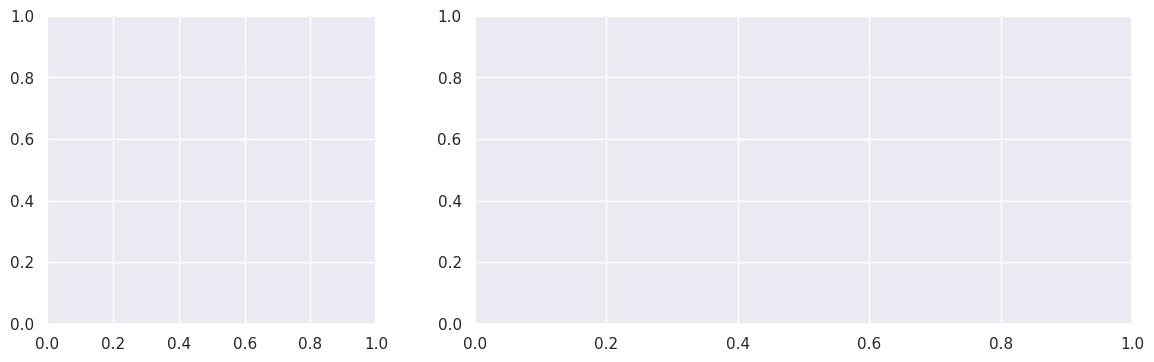

In [33]:
produce_report(end_date, no_days)